## Contract analysis


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [2]:
df_contract_bad = pd.read_csv("../csv_outputs/bad_tokens/master_contract.csv")
df_contract_good = pd.read_csv("../csv_outputs/good_tokens/master_contract.csv")

In [3]:
df_contract_good.head()
df_contract_bad.columns

Index(['token_address', 'chain', 'token_name', 'contract_name', 'verified',
       'owner', 'creator', 'is_hidden_owner', 'is_proxy', 'is_sellable',
       'is_hardcoded_owner', 'has_source_code', 'has_abi', 'total_snippets',
       'honeypot_mechanics_number', 'ownership_manipulation_number',
       'transfer_blocking_number', 'stealth_fee_mechanics_number',
       'liquidity_manipulation_number', 'router_manipulation_number',
       'balance_manipulation_number', 'anti_analysis_features_number',
       'emergency_functions_number'],
      dtype='object')

## How many contracts have renounced their ownership?

C:\Users\Famiglia\AppData\Local\Temp\ipykernel_25844\1862475121.py:34: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.text(i, val + max(good_counts.values) * 0.02, f'{good_percent[i]:.1f}%',


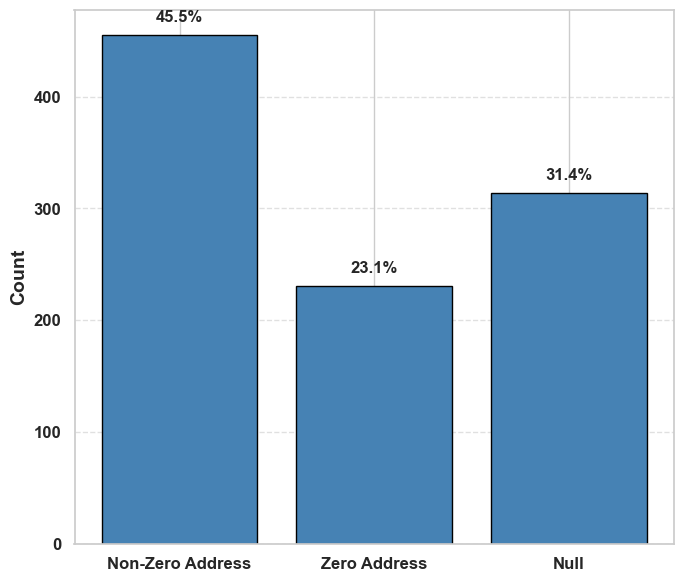

C:\Users\Famiglia\AppData\Local\Temp\ipykernel_25844\1862475121.py:50: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.text(i, val + max(bad_counts.values) * 0.02, f'{bad_percent[i]:.1f}%',


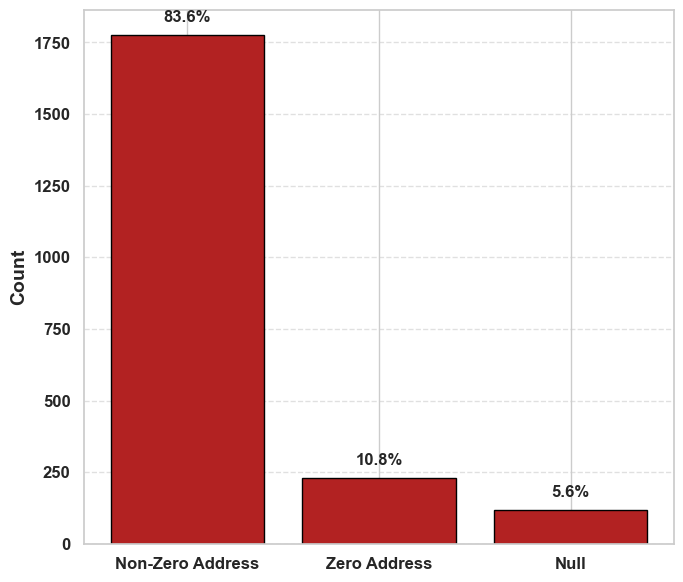

In [12]:
# Define a function to classify owner type
def classify_owner(owner):
    if pd.isna(owner):
        return 'Null'
    elif owner.lower() == '0x0000000000000000000000000000000000000000':
        return 'Zero Address'
    else:
        return 'Non-Zero Address'

# Apply the classification to both DataFrames
df_contract_good['owner_type'] = df_contract_good['owner'].apply(classify_owner)
df_contract_bad['owner_type'] = df_contract_bad['owner'].apply(classify_owner)

# Count owner types
good_counts = df_contract_good['owner_type'].value_counts().reindex(['Non-Zero Address', 'Zero Address', 'Null'], fill_value=0)
bad_counts = df_contract_bad['owner_type'].value_counts().reindex(['Non-Zero Address', 'Zero Address', 'Null'], fill_value=0)

# Calculate percentages
good_percent = good_counts / good_counts.sum() * 100
bad_percent = bad_counts / bad_counts.sum() * 100

import matplotlib.pyplot as plt

# --- First Plot: Good Contracts ---
plt.figure(figsize=(7, 6))
bars = plt.bar(good_counts.index, good_counts.values, color='steelblue', edgecolor='black')
plt.ylabel('Count', fontsize=14, fontweight='bold')
plt.xticks(fontsize=12, fontweight='bold')
plt.yticks(fontsize=12, fontweight='bold')
plt.grid(axis='y', linestyle='--', alpha=0.6)

# Annotate with percentages
for i, val in enumerate(good_counts.values):
    plt.text(i, val + max(good_counts.values) * 0.02, f'{good_percent[i]:.1f}%', 
             ha='center', va='bottom', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

# --- Second Plot: Bad Contracts ---
plt.figure(figsize=(7, 6))
bars = plt.bar(bad_counts.index, bad_counts.values, color='firebrick', edgecolor='black')
plt.ylabel('Count', fontsize=14, fontweight='bold')
plt.xticks(fontsize=12, fontweight='bold')
plt.yticks(fontsize=12, fontweight='bold')
plt.grid(axis='y', linestyle='--', alpha=0.6)

# Annotate with percentages
for i, val in enumerate(bad_counts.values):
    plt.text(i, val + max(bad_counts.values) * 0.02, f'{bad_percent[i]:.1f}%', 
             ha='center', va='bottom', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()




## How many contracts are verified? Have a hidden owner? proxy? sellable? Have a hardcoded owner? have public source code? abi? 

is_hardcoded_owner
False    1378
True      745
Name: count, dtype: int64


C:\Users\Famiglia\AppData\Local\Temp\ipykernel_25844\2756288341.py:2: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['is_hardcoded_owner'] = df['is_hardcoded_owner'].fillna(True)


C:\Users\Famiglia\AppData\Local\Temp\ipykernel_25844\3534331958.py:37: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[col] = df[col].fillna(True)         # ✅ Fill missing values with True
C:\Users\Famiglia\AppData\Local\Temp\ipykernel_25844\3534331958.py:37: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[col] = df[col].fillna(True)         # ✅ Fill missing values with True


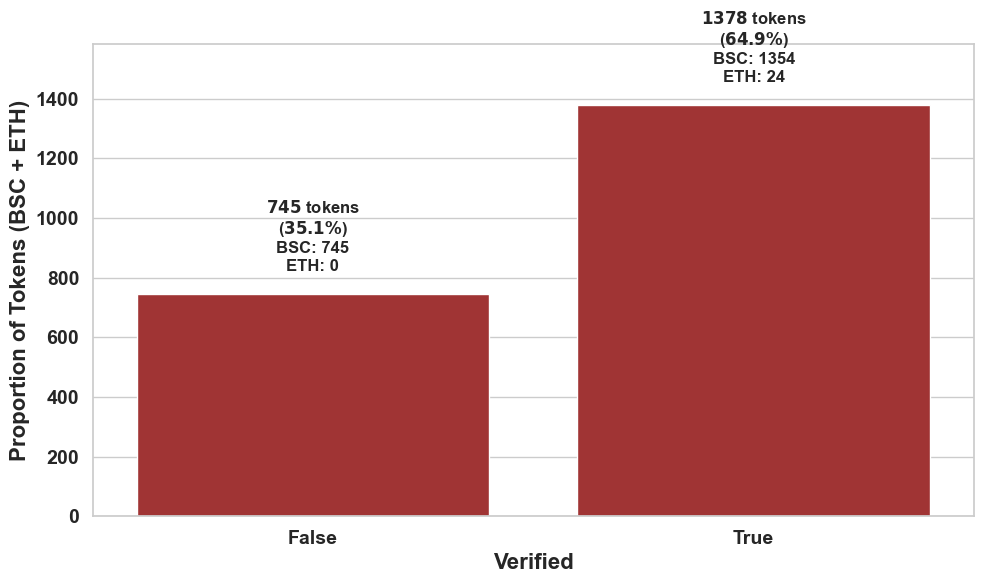

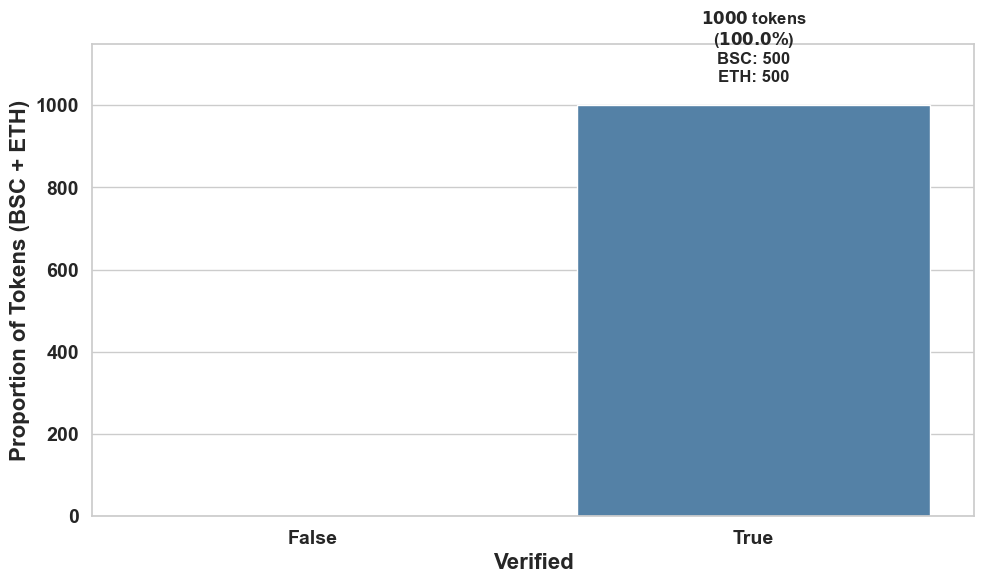

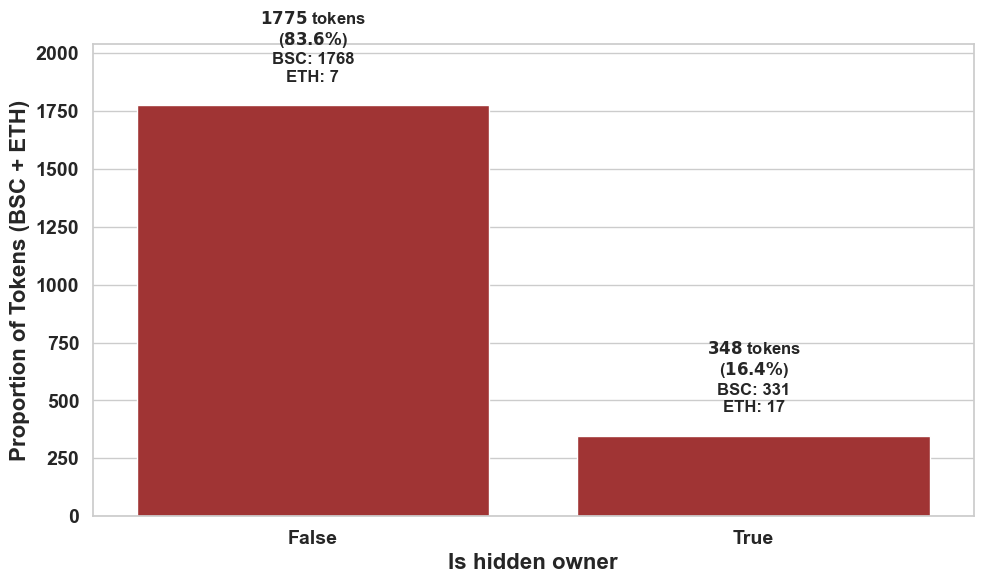

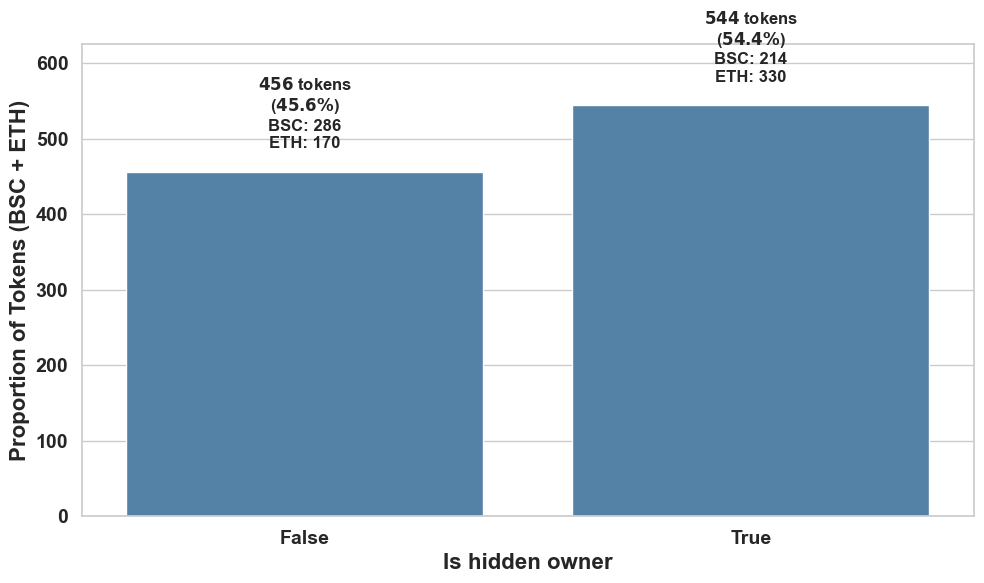

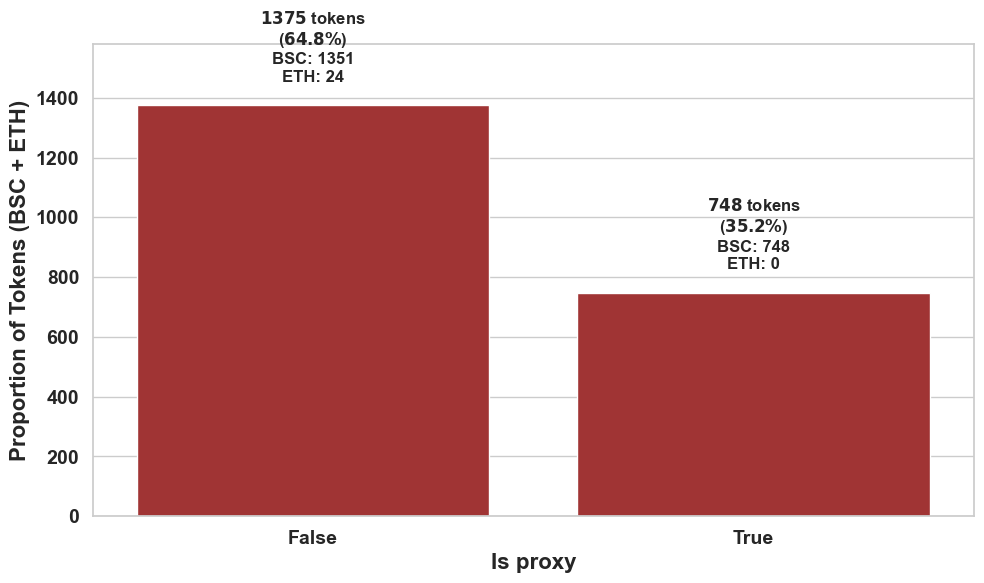

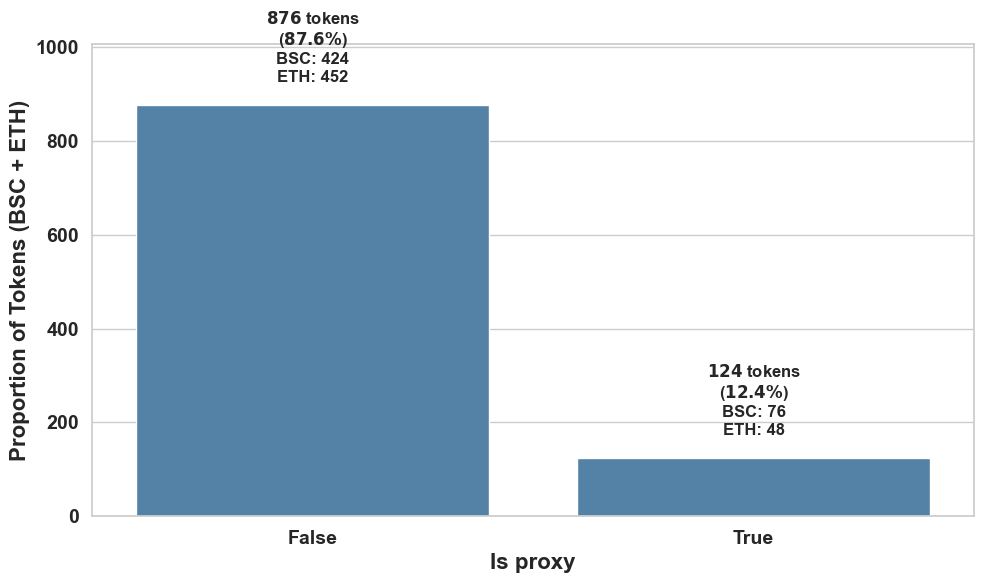

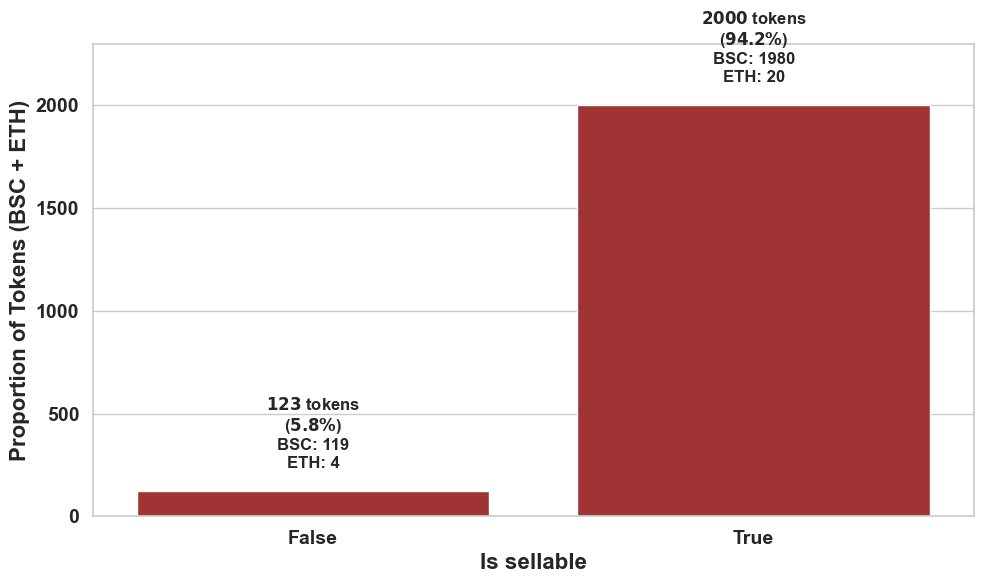

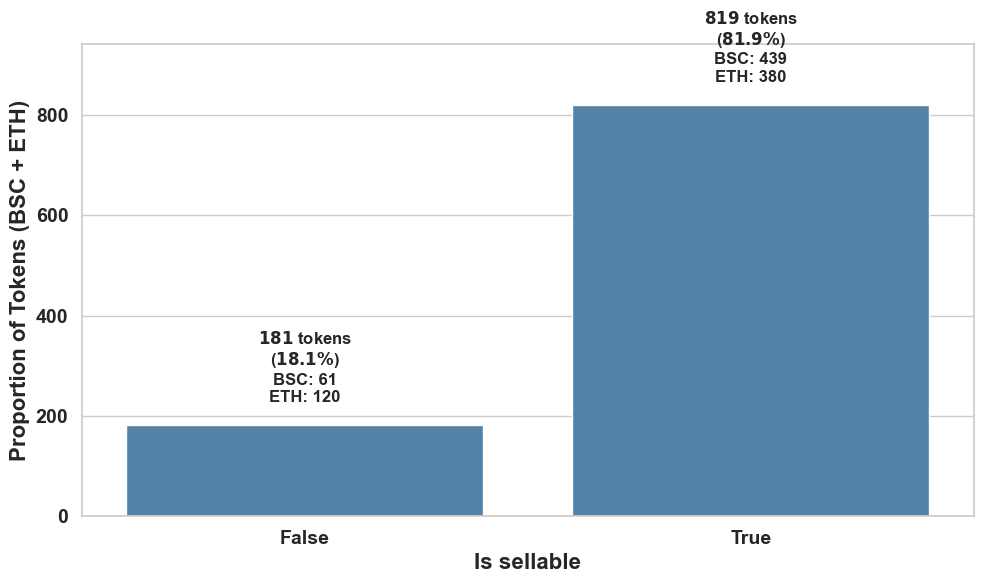

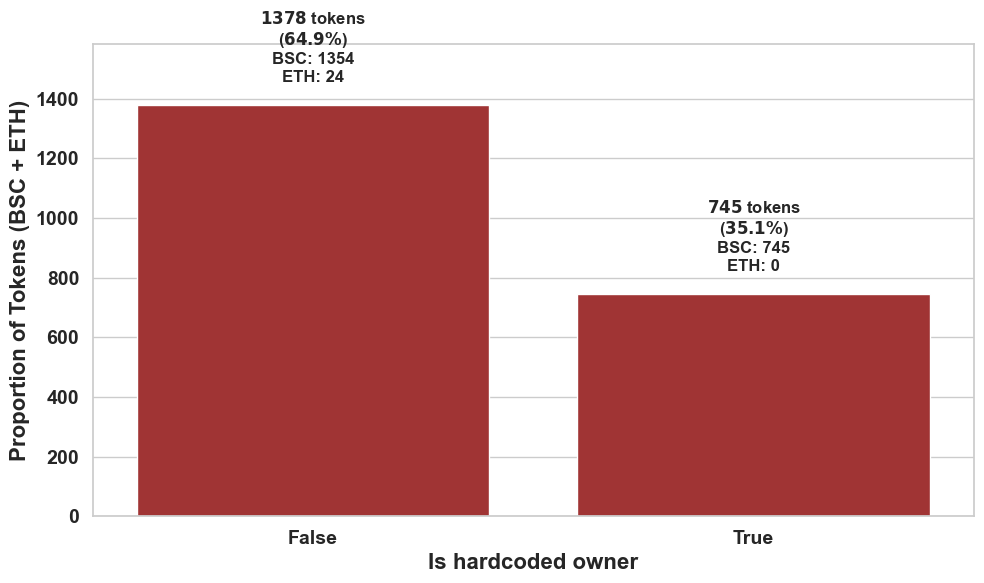

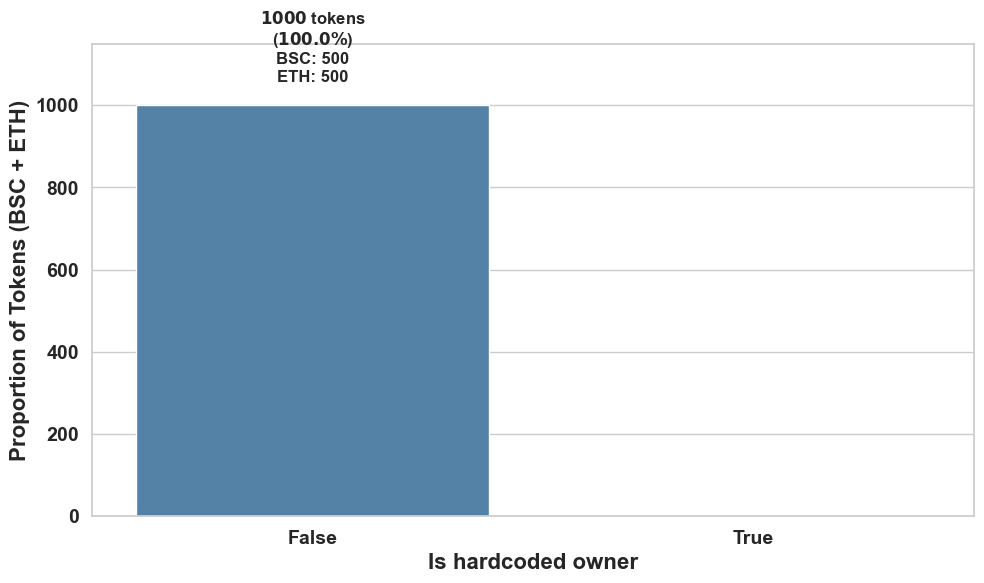

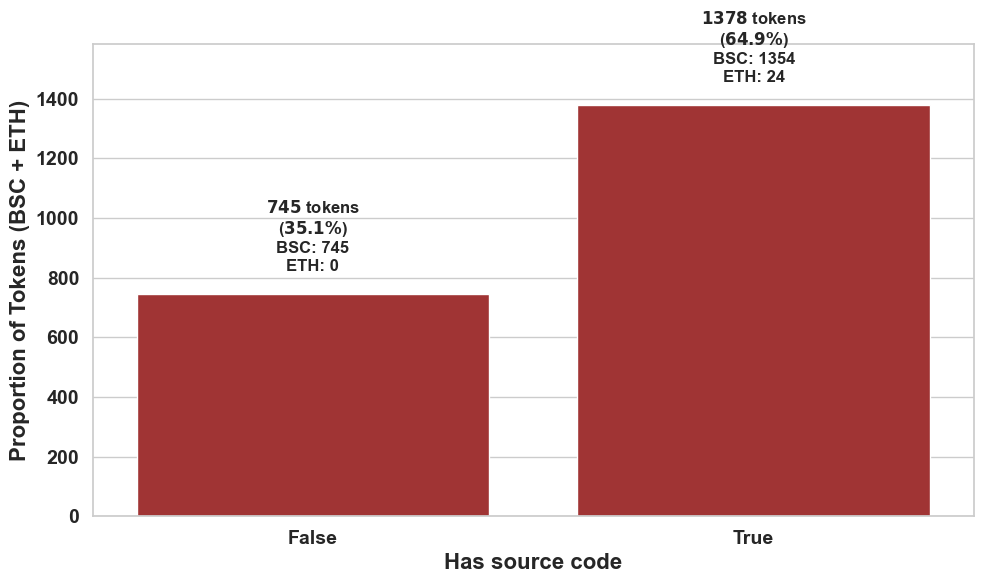

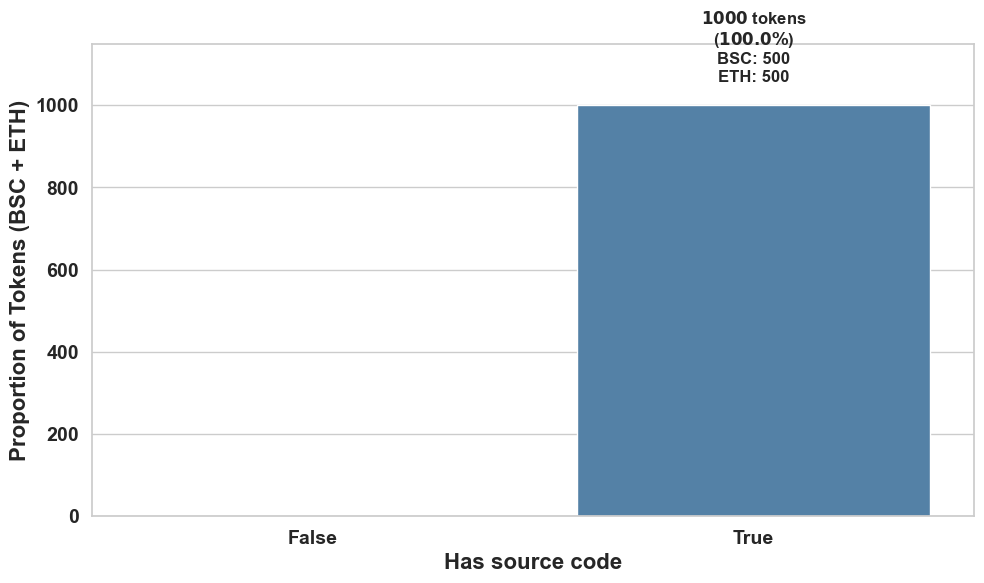

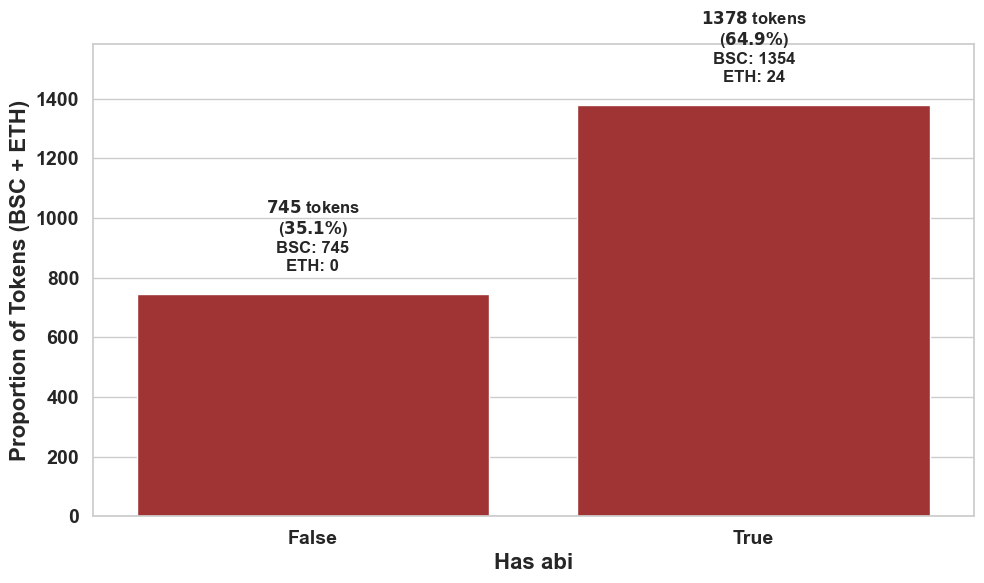

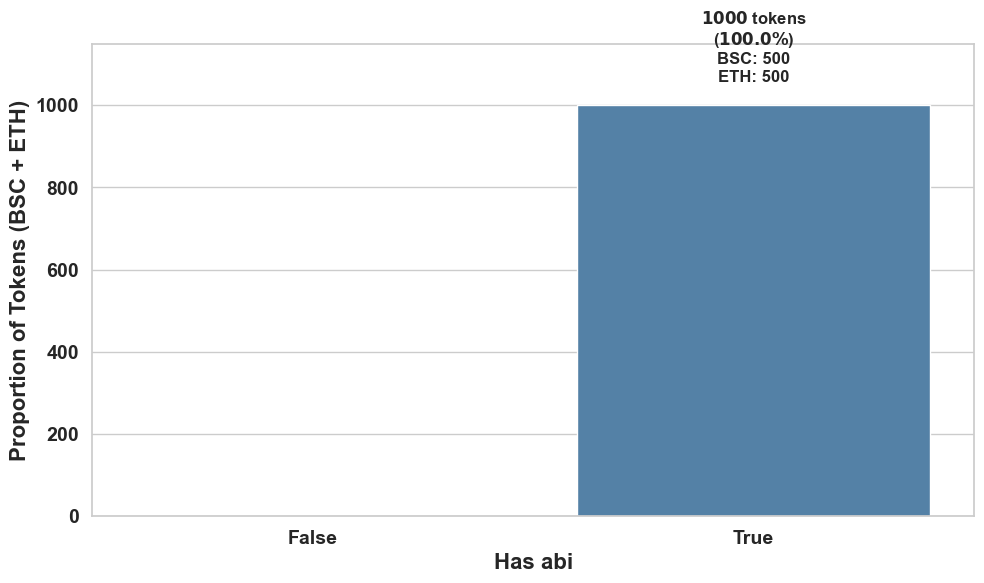

In [32]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Load data
df_contract_bad = pd.read_csv("../csv_outputs/bad_tokens/master_contract.csv")
df_contract_good = pd.read_csv("../csv_outputs/good_tokens/master_contract.csv")

# Add quality column
df_contract_bad['quality'] = 'bad'
df_contract_good['quality'] = 'good'

# Boolean-like columns
bool_cols = ['verified', 'is_hidden_owner', 'is_proxy', 'is_sellable',
             'is_hardcoded_owner', 'has_source_code', 'has_abi']

# Fill missing expected columns if needed
for col in bool_cols:
    for df in [df_contract_bad, df_contract_good]:
        if col not in df.columns:
            df[col] = np.nan

# Normalize to booleans
def to_bool(val):
    val_str = str(val).strip().lower()
    if val_str == 'true':
        return True
    elif val_str == 'false':
        return False
    else:
        return np.nan

for df in [df_contract_bad, df_contract_good]:
    for col in bool_cols:
        df[col] = df[col].apply(to_bool)
        df[col] = df[col].fillna(True)         # ✅ Fill missing values with True
        df[col] = df[col].astype(bool)         # ✅ Force column to bool type

# Combine data
df_all = pd.concat([df_contract_bad, df_contract_good], ignore_index=True)
df_all['chain'] = df_all['chain'].str.lower()

# Color map
color_map = {'bad': 'firebrick', 'good': 'steelblue'}
x_order = [False, True]

# Plot
for col in bool_cols:
    for quality in ['bad', 'good']:
        subset = df_all[df_all['quality'] == quality]
        total_tokens = len(subset)

        counts = subset.groupby([col, 'chain']).size().unstack(fill_value=0)
        total_counts = counts.sum(axis=1)
        percentages = total_counts / total_tokens * 100

        plt.figure(figsize=(10, 6))  # bigger figure

        sns.barplot(
            x=[str(x) for x in x_order],
            y=[total_counts.get(val, 0) for val in x_order],
            order=[str(x) for x in x_order],
            color=color_map[quality]
        )

        # Bigger, bolder labels
        plt.xlabel(col.replace("_", " ").capitalize(), fontsize=16, weight='bold')
        plt.ylabel('Proportion of Tokens (BSC + ETH)', fontsize=16, weight='bold')

        # Bigger, bold ticks
        plt.xticks(fontsize=14, weight='bold')
        plt.yticks(fontsize=14, weight='bold')

        y_max = max(total_counts.values) if not total_counts.empty else 1
        plt.ylim(0, y_max + 0.15 * y_max)

        # Bold, larger annotations with padding
        for i, bool_val in enumerate(x_order):
            total_count = total_counts.get(bool_val, 0)
            pct = percentages.get(bool_val, 0)

            if total_count == 0:
                continue

            bsc_count = counts.loc[bool_val]['bsc'] if 'bsc' in counts.columns and bool_val in counts.index else 0
            eth_count = counts.loc[bool_val]['eth'] if 'eth' in counts.columns and bool_val in counts.index else 0

            annotation_text = (
                f"$\\bf{{{total_count}}}$ tokens\n"
                f"($\\bf{{{pct:.1f}\\%}}$)\n"
                f"BSC: {bsc_count}\n"
                f"ETH: {eth_count}"
            )

            plt.text(
                i, total_count + y_max * 0.05,  # a bit more padding above bar
                annotation_text,
                ha='center', va='bottom', fontsize=12, fontweight='bold'
            )

        plt.tight_layout()
        plt.show()


## Snippets analysis

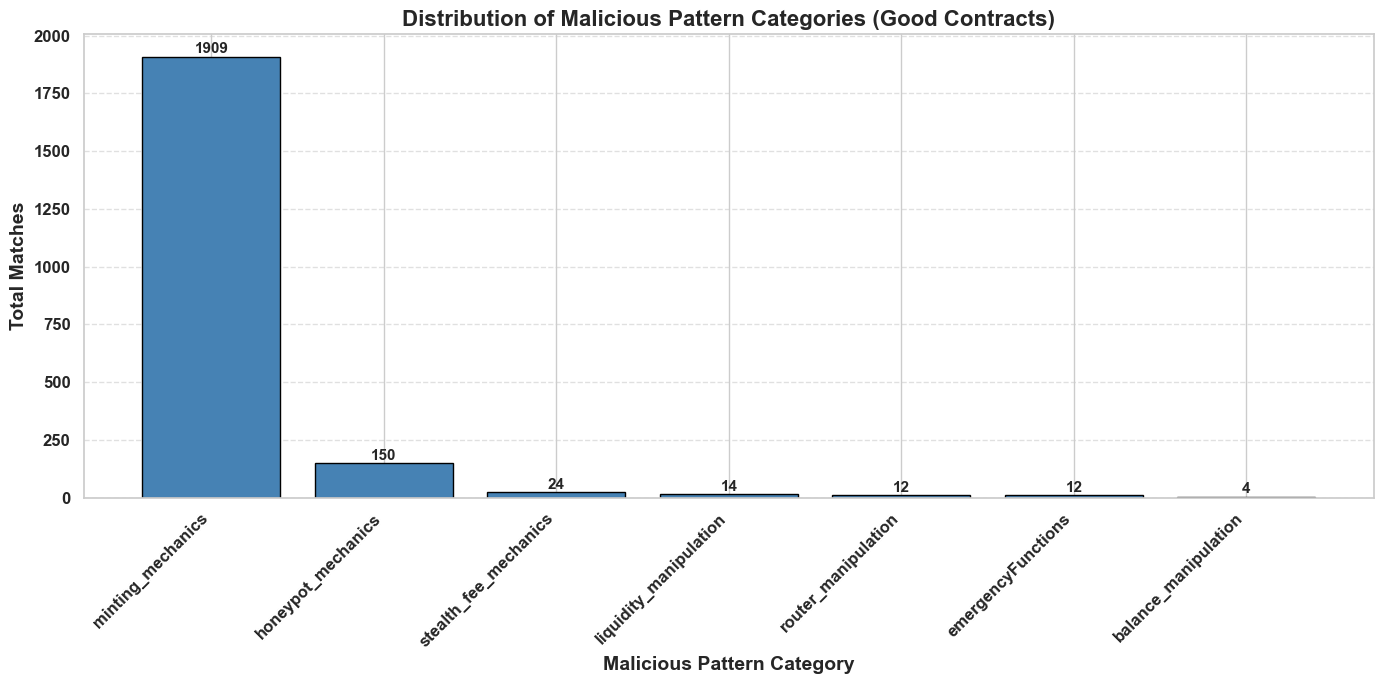

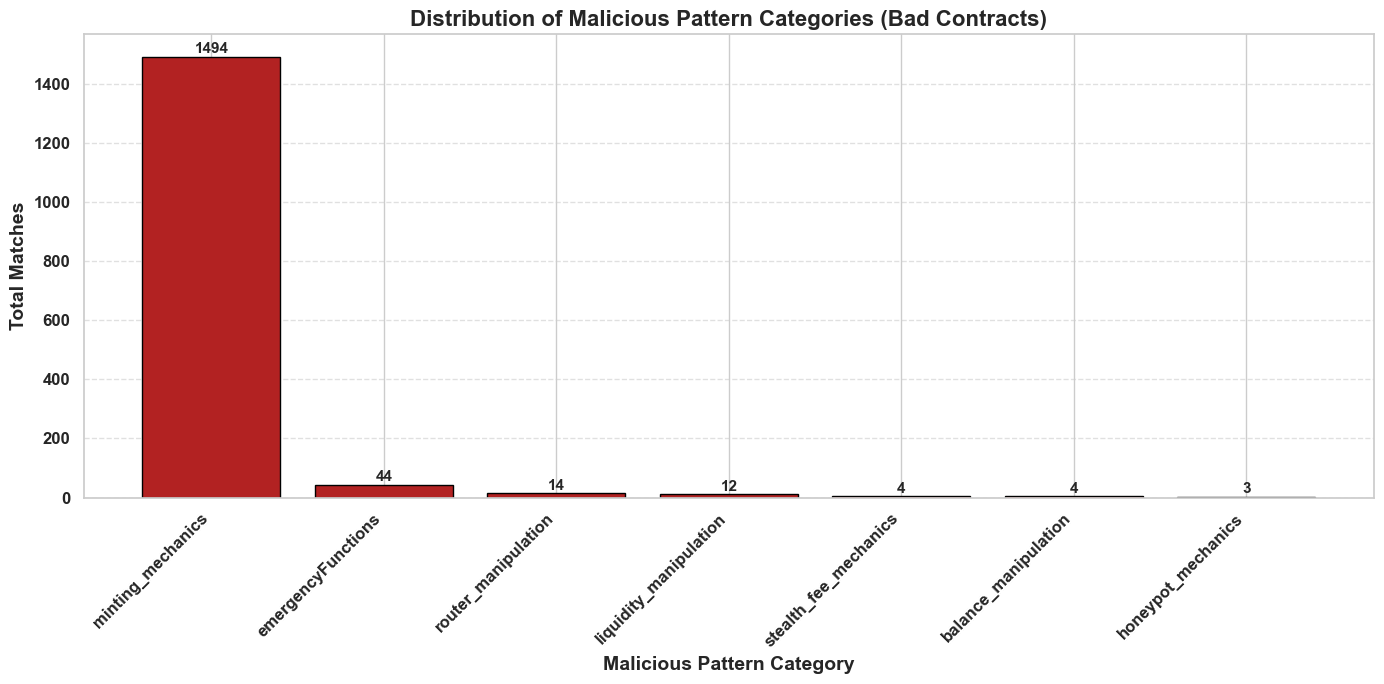

In [10]:
import os
import json
import matplotlib.pyplot as plt
from collections import defaultdict

def plot_pattern_distribution(analysis_folder: str, title_suffix: str = ""):
    """
    Scans a folder of JSON contract analysis files and plots a bar chart 
    showing the total count of each malicious pattern category.

    Parameters:
    - analysis_folder (str): Path to the folder containing JSON files.
    - title_suffix (str): Used to determine coloring and title labeling.
    """
    category_counts = defaultdict(int)

    # Scan all JSON files in folder
    for filename in os.listdir(analysis_folder):
        if filename.endswith('.json'):
            filepath = os.path.join(analysis_folder, filename)

            try:
                with open(filepath, 'r') as f:
                    data = json.load(f)

                # Expected structure
                if 'patterns_found' in data and 'total_matches' in data:
                    for category, content in data['patterns_found'].items():
                        category_counts[category] += content.get('count', 0)

            except Exception as e:
                print(f"Error reading {filename}: {e}")

    if not category_counts:
        print(f"No valid data found in {analysis_folder}")
        return

    # Sorting
    sorted_categories = sorted(category_counts.items(), key=lambda x: x[1], reverse=True)
    labels = [cat for cat, _ in sorted_categories]
    counts = [count for _, count in sorted_categories]

    # Set color based on title
    if "bad" in title_suffix.lower():
        bar_color = 'firebrick'
    else:
        bar_color = 'steelblue'

    # Plotting
    plt.figure(figsize=(14, 7))
    bars = plt.bar(labels, counts, color=bar_color, edgecolor='black')
    plt.xticks(rotation=45, ha='right', fontsize=12, fontweight='bold')
    plt.yticks(fontsize=12, fontweight='bold')
    plt.title(f'Distribution of Malicious Pattern Categories {title_suffix}', fontsize=16, fontweight='bold')
    plt.xlabel('Malicious Pattern Category', fontsize=14, fontweight='bold')
    plt.ylabel('Total Matches', fontsize=14, fontweight='bold')
    plt.tight_layout()

    # Annotate bars
    for bar, count in zip(bars, counts):
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2.0, height + 1, f'{count}', 
                 ha='center', va='bottom', fontsize=11, fontweight='bold')

    plt.grid(axis='y', linestyle='--', alpha=0.6)
    plt.show()


bad_analysis_folder = 'C:/Users/Famiglia/Desktop/Amedeo/TESI/Progetto_tesi/thesis/contract_analysis_results/bad_contract_analysis_results'
good_analysis_folder = 'C:/Users/Famiglia/Desktop/Amedeo/TESI/Progetto_tesi/thesis/contract_analysis_results/good_contract_analysis_results'

plot_pattern_distribution(good_analysis_folder, "(Good Contracts)")
plot_pattern_distribution(bad_analysis_folder, "(Bad Contracts)")

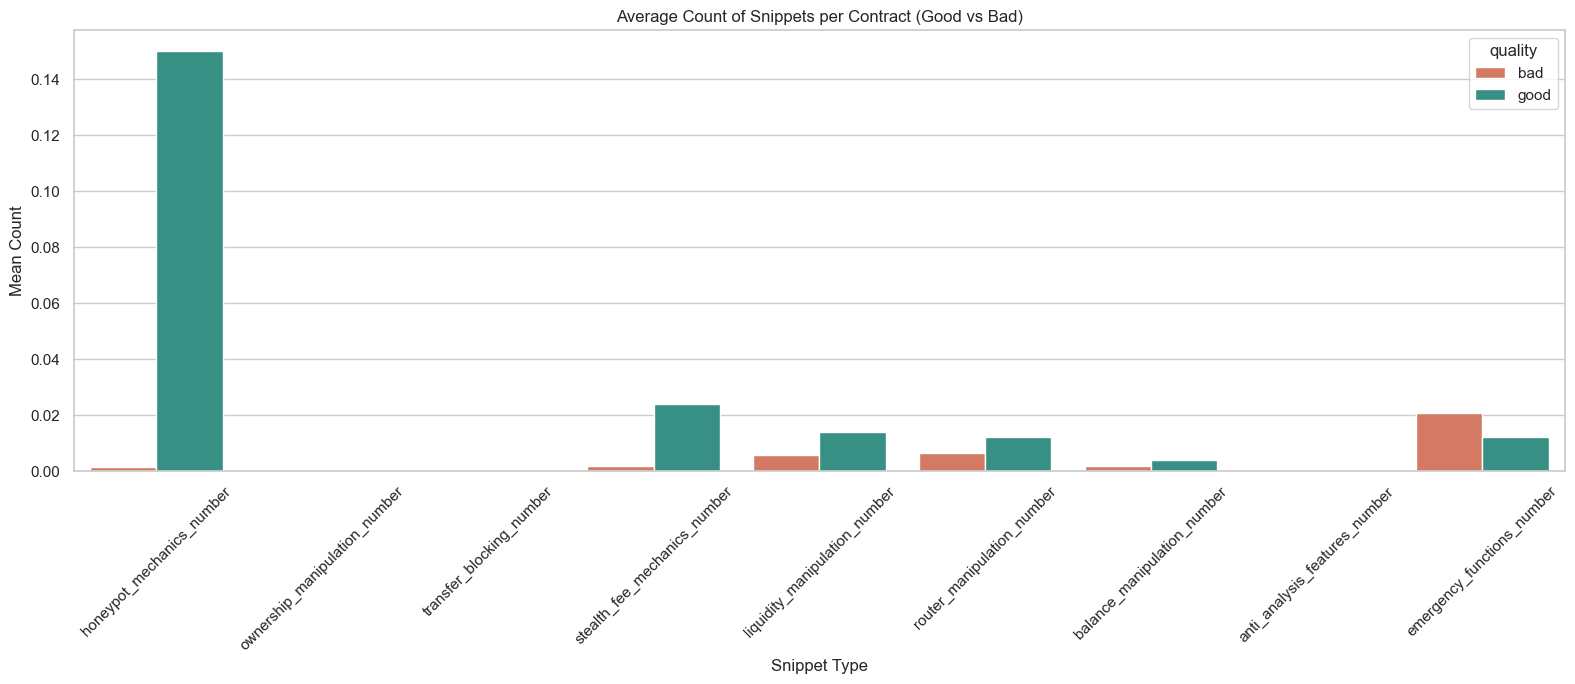

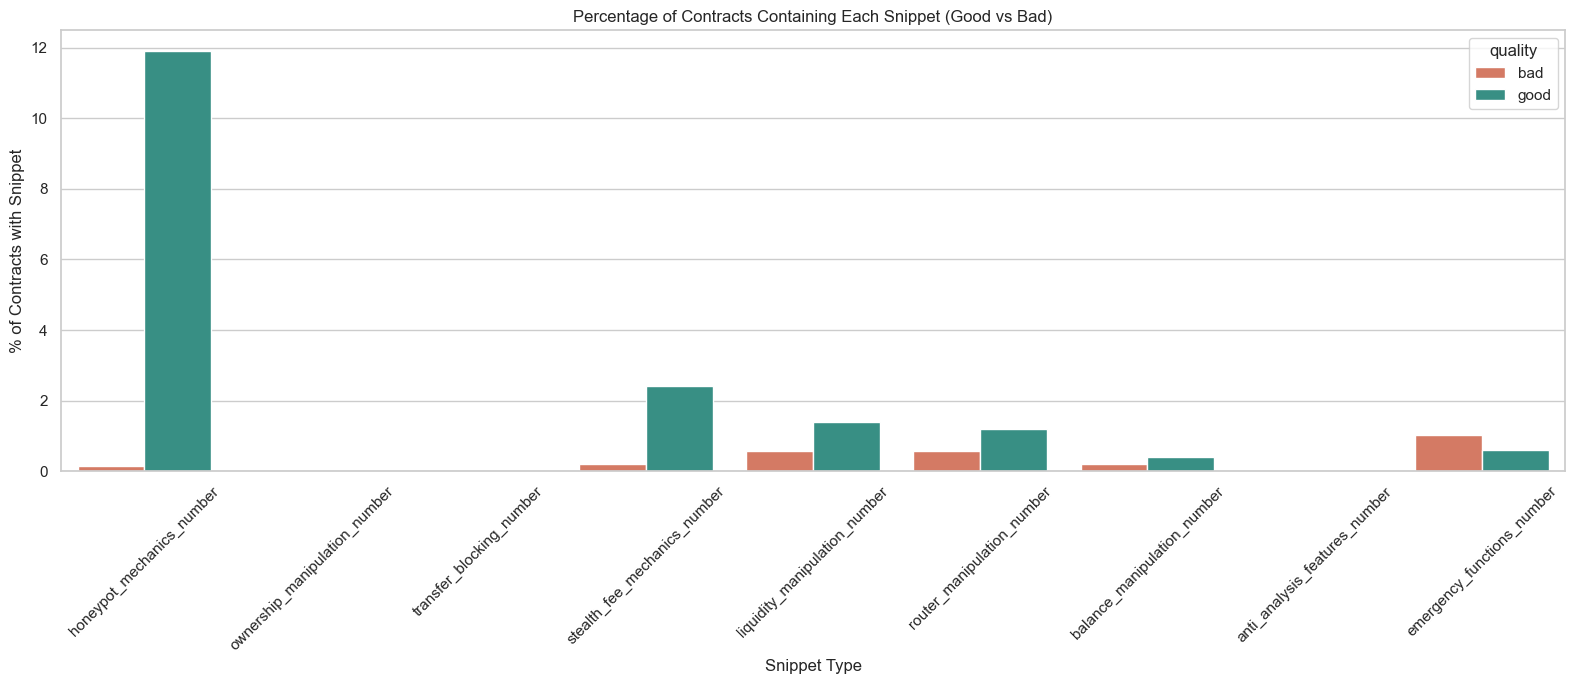

In [7]:
# Load data
df_contract_bad = pd.read_csv("../csv_outputs/bad_tokens/master_contract.csv")
df_contract_good = pd.read_csv("../csv_outputs/good_tokens/master_contract.csv")

# Snippet-related columns
snippet_cols = [
    'honeypot_mechanics_number',
    'ownership_manipulation_number',
    'transfer_blocking_number',
    'stealth_fee_mechanics_number',
    'liquidity_manipulation_number',
    'router_manipulation_number',
    'balance_manipulation_number',
    'anti_analysis_features_number',
    'emergency_functions_number'
]

# Set seaborn theme
sns.set_theme(style="whitegrid")
plt.rcParams["figure.figsize"] = (14, 6)

# --------------- OPTION A: Mean Count per Contract ----------------

mean_counts = df_all.groupby('quality')[snippet_cols].mean().T
mean_counts = mean_counts.reset_index().rename(columns={'index': 'snippet'})

fig, ax = plt.subplots(figsize=(16, 7))
sns.barplot(
    data=mean_counts.melt(id_vars='snippet', var_name='quality', value_name='mean_count'),
    x='snippet', y='mean_count', hue='quality', ax=ax,
    palette=['#e76f51', '#2a9d8f']
)

ax.set_title("Average Count of Snippets per Contract (Good vs Bad)")
ax.set_ylabel("Mean Count")
ax.set_xlabel("Snippet Type")
ax.tick_params(axis='x', rotation=45)
plt.tight_layout()
plt.show()

# --------------- OPTION B: Presence Rate per Contract ----------------

presence_df = df_all.copy()
for col in snippet_cols:
    presence_df[col] = presence_df[col].fillna(0)
    presence_df[col] = (presence_df[col] > 0).astype(int)

presence_rate = presence_df.groupby('quality')[snippet_cols].mean().T * 100
presence_rate = presence_rate.reset_index().rename(columns={'index': 'snippet'})

fig, ax = plt.subplots(figsize=(16, 7))
sns.barplot(
    data=presence_rate.melt(id_vars='snippet', var_name='quality', value_name='presence_pct'),
    x='snippet', y='presence_pct', hue='quality', ax=ax,
    palette=['#e76f51', '#2a9d8f']
)

ax.set_title("Percentage of Contracts Containing Each Snippet (Good vs Bad)")
ax.set_ylabel("% of Contracts with Snippet")
ax.set_xlabel("Snippet Type")
ax.tick_params(axis='x', rotation=45)
plt.tight_layout()
plt.show()

